In [1]:
import jax
import jax.numpy as np
from jax import jit, grad, random
from jax.experimental import stax, optimizers

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import os, imageio

rand_key = random.PRNGKey(0)

## Implement Madam

In [2]:
@optimizers.optimizer
def madam(step_size=0.01, b2=0.999, g_bound=10):
  step_size = optimizers.make_schedule(step_size)
  def init(x0):
    s0 = np.sqrt(np.mean(x0*x0))                        # Initial scale.
    v0 = np.zeros_like(x0)                              # 2nd moment.
    return x0, s0, v0
  def update(i, g, state):
    x, s, v = state
    v = (1 - b2) * np.square(g) + b2 * v                # Update 2nd moment.
    vhat = v / (1 - b2 ** (i + 1))                      # Bias correction.
    g_norm = np.nan_to_num( g / np.sqrt(vhat) )         # Normalise gradient.
    g_norm = np.clip( g_norm, -g_bound, g_bound )       # Bound g.
    x *= np.exp( -step_size(i) * g_norm * np.sign(x) )  # Multiplicative update.
    x = np.clip( x, -s, s)                              # Bound parameters.
    return x, s, v
  def get_params(state):
    x, s, v = state
    return x
  return init, update, get_params

The rest of this notebook is from the Fourier features codebase (https://people.eecs.berkeley.edu/~bmild/fourfeat/) and is under the MIT license.

## Set up data

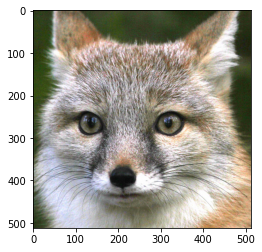

In [3]:
# Download image, take a square crop from the center
image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
img = imageio.imread(image_url)[..., :3] / 255.
c = [img.shape[0]//2, img.shape[1]//2]
r = 256
img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

plt.imshow(img)
plt.show()

# Create input pixel coordinates in the unit square
coords = np.linspace(0, 1, img.shape[0], endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [x_test, img]
train_data = [x_test[::2,::2], img[::2,::2]]

# Model and training code

Our model is a coordinate-based multilayer perceptron. In this example, for each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

In [4]:
# Fourier feature mapping
def input_mapping(x, B): 
  if B is None:
    return x
  else:
    x_proj = (2.*np.pi*x) @ B.T
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)


# JAX network definition
def make_network(num_layers, num_channels):
    layers = []
    for i in range(num_layers-1):
        layers.append(stax.Dense(num_channels))
        layers.append(stax.Relu)
    layers.append(stax.Dense(3))
    layers.append(stax.Sigmoid)
    return stax.serial(*layers)


# Train model with given hyperparameters and data
def train_model(network_size, optim, learning_rate, iters, B, train_data, test_data):

    init_fn, apply_fn = make_network(*network_size)

    model_pred = jit(lambda params, x: apply_fn(params, input_mapping(x, B)))
    model_loss = jit(lambda params, x, y: .5 * np.mean((model_pred(params, x) - y) ** 2))
    model_psnr = jit(lambda params, x, y: -10 * np.log10(2.*model_loss(params, x, y)))
    model_grad_loss = jit(lambda params, x, y: jax.grad(model_loss)(params, x, y))

    opt_init, opt_update, get_params = optim(learning_rate)
    opt_update = jit(opt_update)

    _, params = init_fn(rand_key, (-1, input_mapping(train_data[0], B).shape[-1]))
    opt_state = opt_init(params)

    train_psnrs = []
    test_psnrs = []
    pred_imgs = []
    xs = []
    for i in tqdm(range(iters), desc='train iter', leave=False):
        opt_state = opt_update(i, model_grad_loss(get_params(opt_state), *train_data), opt_state)

        if i % 25 == 0:
            train_psnrs.append(model_psnr(get_params(opt_state), *train_data))
            test_psnrs.append(model_psnr(get_params(opt_state), *test_data))
            pred_imgs.append(model_pred(get_params(opt_state), test_data[0]))
            xs.append(i)
    
    return {
        'state': get_params(opt_state),
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
        'pred_imgs' : np.stack(pred_imgs),
        'xs': xs,
    }

## Train networks with different depths

We compare Madam and Adam at depth 5 and depth 75. At depth 75 we try two learning rates for each algorithm.

In [5]:
adam = optimizers.adam
expts = [ (madam, 5,  1e-2), 
          (madam, 75, 1e-2),
          (madam, 75, 1e-3), 
          (adam,  5,  1e-4),  
          (adam,  75, 1e-4), 
          (adam,  75, 1e-5) ]

iters = 2000
B_gauss = 10 * random.normal(rand_key, (256, 2)) # Gaussian Fourier features

# This should take about 2 hours.
outputs = {}
for optim, depth, lr in tqdm(expts):
  network_size = (depth, 256)
  outputs[(depth,optim.__name__,lr)] = train_model(network_size, optim, lr, iters, B_gauss, train_data, test_data)

## Plot results

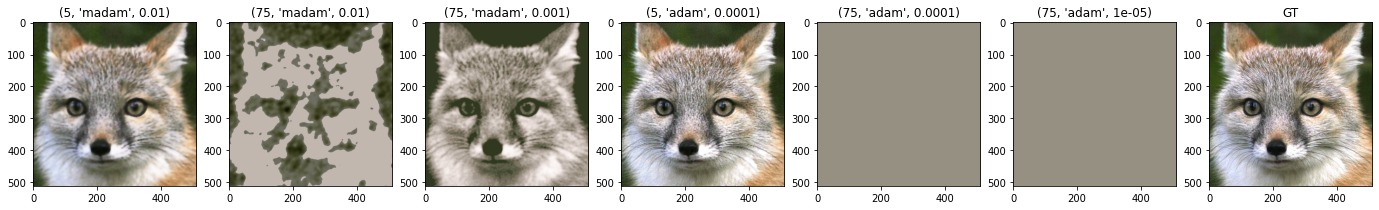

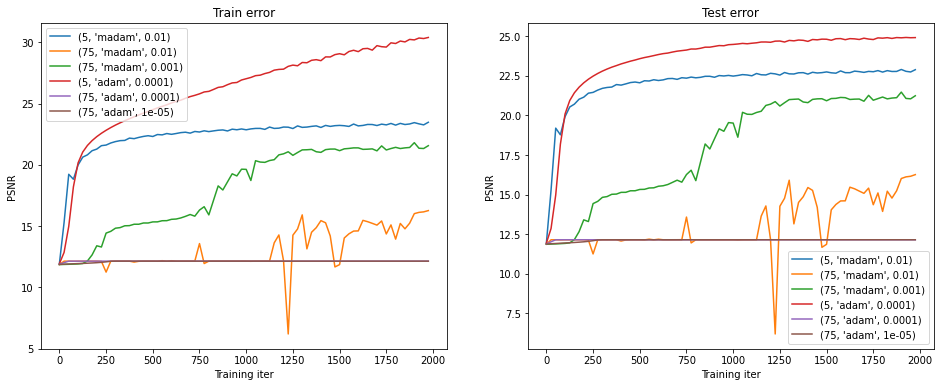

In [6]:
# Show final network outputs

plt.figure(figsize=(24,4))
N = len(outputs)
for i, k in enumerate(outputs):
    plt.subplot(1,N+1,i+1)
    plt.imshow(outputs[k]['pred_imgs'][-1])
    plt.title(k)
plt.subplot(1,N+1,N+1)
plt.imshow(img)
plt.title('GT')
plt.show()

# Plot train/test error curves

plt.figure(figsize=(16,6))

plt.subplot(121)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['train_psnrs'], label=k)
plt.title('Train error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.subplot(122)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['test_psnrs'], label=k)
plt.title('Test error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.show()

Madam "jitters" about the solution (as shown in the videos below) and learning rate decay would fix this. But notice that at depth 75, Adam completely failed to learn.

In [7]:
# Save out video
all_preds = np.concatenate([outputs[n]['pred_imgs'] for n in outputs], axis=-2)
data8 = (255*np.clip(all_preds,0,1)).astype(np.uint8)
f = os.path.join('training_convergence.mp4')
imageio.mimwrite(f, data8, fps=20)

# Display video inline
from IPython.display import HTML
from base64 import b64encode
mp4 = open(f,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'''
<video width=1000 controls autoplay loop>
      <source src="{data_url}" type="video/mp4">
</video>
<table width="1000" cellspacing="0" cellpadding="0">
  <tr>{''.join(N*[f'<td width="{1000//len(outputs)}"></td>'])}</tr>
  <tr>{''.join(N*['<td style="text-align:center">{}</td>'])}</tr>
</table>
'''.format(*list(outputs.keys())))